# Demo on lung dataset

In [1]:
%load_ext autoreload
%autoreload 2

In [40]:
import os,sys
import numpy as np
import pandas as pd
import scanpy as sc
import scvi

import q2r_uncertainty
import matplotlib.pyplot as plt
# import diff2atlas


In [3]:
dir(q2r_uncertainty)

['__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'q2r_simulation',
 'train_models',
 'train_scVI',
 'uncertainty_metrics']

In [4]:
## Some utils
def clean_pop_name(string):
   return(''.join(e if e.isalnum() else '_' for e in string))

### Load dataset

In [15]:
# if os.path.exists('/home/jupyter/'):
#     outpath = '/home/jupyter/mount/gdrive/query2reference/processed_data/'
# elif os.path.exists('/home/jovyan/'):
#     outpath = '/home/jovyan/mount/gdrive/query2reference/processed_data/'

# h5ad_file = 'lung.h5ad'
# adata = sc.read_h5ad(outpath + h5ad_file)

In [31]:
adata = sc.read(
    "data/lung_atlas.h5ad",
    backup_url="https://figshare.com/ndownloader/files/24539942",
)

### Split into atlas-condition-control and simulate condition-specific pop

In [32]:
population_obs = 'cell_type'
perturb_pop=['Secretory']
batch_obs='batch'
query_batch=['A6']
ctrl_batch=['A5']

q2r_uncertainty.q2r_simulation.simulate_query_reference_batch(
            adata, perturb_pop = perturb_pop, population_obs = population_obs,
            batch_obs = batch_obs, query_batch = query_batch, ctrl_batch=ctrl_batch
        )

## Checks 
any(adata.obs[adata.obs[population_obs].isin(perturb_pop)]['is_train']==1)
any(adata.obs[adata.obs[population_obs].isin(perturb_pop)]['is_ctrl']==1)

False

In [33]:
adata_ref = adata[adata.obs['is_train']==1].copy()
adata_ctrl = adata[adata.obs['is_ctrl']==1].copy()
adata_query = adata[adata.obs['is_test']==1].copy()

In [35]:
## Feature selection on reference only
n_hvgs = 5000
overwrite_models = False

if 'log1p' not in adata_ref.uns.keys():
    sc.pp.normalize_per_cell(adata_ref)
    sc.pp.log1p(adata_ref)

sc.pp.highly_variable_genes(
    adata_ref,
    n_top_genes=n_hvgs,
    subset=True
)

hvgs = adata_ref.var_names.values

In [36]:
sim_id = f"queryBatch{'-'.join(query_batch)}_ctrlBatch{'-'.join(ctrl_batch)}_perturb_{population_obs}{clean_pop_name('-'.join(perturb_pop))}"
if not os.path.exists(outpath + h5ad_file.split('.h5ad')[0] + "_models"):
    print('bubi')
    os.mkdir(h5ad_file.split('.h5ad')[0] + "_models")

In [38]:
## Train reference model
if not os.path.exists(outpath + h5ad_file.split('.h5ad')[0] + f"_models/model_reference_{sim_id}/") or overwrite_models:
    vae_ref = q2r_uncertainty.train_models.train_scVI._train_model(adata_ref, hvgs, batch_col=batch_obs)
    vae_ref.save(outpath + h5ad_file.split('.h5ad')[0] + f"_models/model_reference_{sim_id}/", overwrite=True)

INFO     Using batches from adata.obs["batch"]                                               
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.layers["counts"]                                              
INFO     Successfully registered anndata object containing 26031 cells, 5000 vars, 14        
         batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.


KeyboardInterrupt



In [ ]:
## Map query datasets 
vae_ctrl_fit = q2r_uncertainty.train_models.train_scVI._fit_model(adata_ctrl, vae_ref, batch_col=batch_obs)
vae_ctrl_fit.save(outpath + h5ad_file.split('.h5ad')[0] + f"_models/model_ctrl_fit_{sim_id}/", overwrite=True)
vae_query_fit_ref = q2r_uncertainty.train_models.train_scVI._fit_model(adata_query, vae_ref, batch_col=batch_obs)
vae_query_fit_ref.save(outpath + h5ad_file.split('.h5ad')[0] + f"_models/model_query_fit_reference_{sim_id}/", overwrite=True)


In [41]:
## Load saved mapping models
adata_ctrl = adata_ctrl[:,hvgs].copy()
adata_query = adata_query[:,hvgs].copy()
vae_ctrl_fit       = scvi.model.SCVI.load(outpath + h5ad_file.split('.h5ad')[0] + f"_models/model_ctrl_fit_{sim_id}/", adata=adata_ctrl)
vae_query_fit_ref  = scvi.model.SCVI.load(outpath + h5ad_file.split('.h5ad')[0] + f"_models/model_query_fit_reference_{sim_id}/", adata=adata_query)

INFO     .obs[_scvi_labels] not found in target, assuming every cell is same category        


INFO:scvi.data._anndata:.obs[_scvi_labels] not found in target, assuming every cell is same category


INFO     Using data from adata.layers["counts"]                                              


INFO:scvi.data._anndata:Using data from adata.layers["counts"]


INFO     Registered keys:['X', 'batch_indices', 'labels']                                    


INFO:scvi.data._anndata:Registered keys:['X', 'batch_indices', 'labels']


INFO     Successfully registered anndata object containing 2191 cells, 5000 vars, 15 batches,
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


INFO:scvi.data._anndata:Successfully registered anndata object containing 2191 cells, 5000 vars, 15 batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra continuous covariates.


INFO     .obs[_scvi_labels] not found in target, assuming every cell is same category        


INFO:scvi.data._anndata:.obs[_scvi_labels] not found in target, assuming every cell is same category


INFO     Using data from adata.layers["counts"]                                              


INFO:scvi.data._anndata:Using data from adata.layers["counts"]


INFO     Registered keys:['X', 'batch_indices', 'labels']                                    


INFO:scvi.data._anndata:Registered keys:['X', 'batch_indices', 'labels']


INFO     Successfully registered anndata object containing 2410 cells, 5000 vars, 15 batches,
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


INFO:scvi.data._anndata:Successfully registered anndata object containing 2410 cells, 5000 vars, 15 batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra continuous covariates.


INFO     Using data from adata.layers["counts"]                                              


INFO:scvi.data._anndata:Using data from adata.layers["counts"]


INFO     Registered keys:['X', 'batch_indices', 'labels']                                    


INFO:scvi.data._anndata:Registered keys:['X', 'batch_indices', 'labels']


INFO     Successfully registered anndata object containing 2410 cells, 5000 vars, 2 batches, 
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


INFO:scvi.data._anndata:Successfully registered anndata object containing 2410 cells, 5000 vars, 2 batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra continuous covariates.


In [42]:
## Fix batch categories 
batch_mappings = adata_query.uns["_scvi"]['categorical_mappings']['_scvi_batch'].copy()
adata_query.uns["_scvi"]['categorical_mappings']['_scvi_batch']['mapping'] = adata_query.obs[batch_mappings['original_key']].cat.categories.values
batch_mappings = adata_query.uns["_scvi"]['categorical_mappings']['_scvi_batch'].copy()

adata_query.uns["_scvi"]['categorical_mappings']['_scvi_batch']['mapping'] = adata_query.obs[batch_mappings['original_key']].cat.categories.values
adata_query.obsm['X_scVI_fit_ref']  = vae_query_fit_ref.get_latent_representation()
adata_ctrl.obsm['X_scVI_fit_ref']  = vae_ctrl_fit.get_latent_representation()

INFO     Using data from adata.layers["counts"]                                              


INFO:scvi.data._anndata:Using data from adata.layers["counts"]


INFO     Registered keys:['X', 'batch_indices', 'labels']                                    


INFO:scvi.data._anndata:Registered keys:['X', 'batch_indices', 'labels']


INFO     Successfully registered anndata object containing 2410 cells, 5000 vars, 15 batches,
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


INFO:scvi.data._anndata:Successfully registered anndata object containing 2410 cells, 5000 vars, 15 batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra continuous covariates.


In [44]:
adata_ctrl

AnnData object with n_obs × n_vars = 2191 × 5000
    obs: 'dataset', 'location', 'nGene', 'nUMI', 'patientGroup', 'percent.mito', 'protocol', 'sanger_type', 'size_factors', 'sampling_method', 'batch', 'cell_type', 'donor', 'is_train', 'is_test', 'is_ctrl', '_scvi_batch', '_scvi_labels'
    uns: '_scvi'
    obsm: 'X_scVI_fit_ref'
    layers: 'counts'

## Co-embedding of control and query

In [52]:
adata_merged = adata_query.concatenate(adata_ctrl, batch_key='dataset', batch_categories=['condition', 'control'])

In [53]:
sc.pp.neighbors(adata_merged, n_neighbors=30, use_rep="X_scVI_fit_ref")
sc.tl.umap(adata_merged)

In [65]:
adata_merged.obs['is_query_pop'] = adata_merged.obs[population_obs].isin(perturb_pop).astype('int')

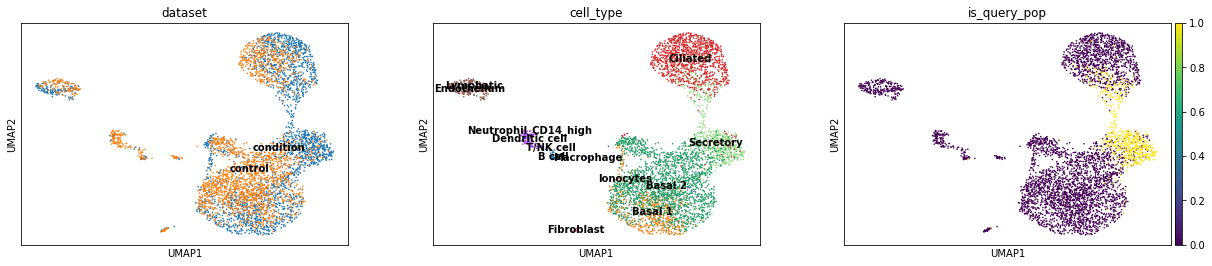

In [66]:
sc.pl.umap(adata_merged, color=['dataset', 'cell_type', 'is_query_pop'], size=10, legend_loc='on data')

In [67]:
adata_merged

AnnData object with n_obs × n_vars = 4601 × 5000
    obs: 'dataset', 'location', 'nGene', 'nUMI', 'patientGroup', 'percent.mito', 'protocol', 'sanger_type', 'size_factors', 'sampling_method', 'batch', 'cell_type', 'donor', 'is_train', 'is_test', 'is_ctrl', '_scvi_batch', '_scvi_labels', 'is_query_pop'
    uns: 'neighbors', 'umap', 'dataset_colors', 'cell_type_colors'
    obsm: 'X_scVI_fit_ref', 'X_umap'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

## CellTypist model

In [69]:
pip install celltypist

     |████████████████████████████████| 5.3 MB 3.8 MB/s            
Note: you may need to restart the kernel to use updated packages.


In [70]:
import celltypist

In [77]:
adata_ref.X = adata_ref.layers['counts'].copy()
sc.pp.normalize_total(adata_ref, target_sum=10000)
sc.pp.log1p(adata_ref)

In [ ]:
new_model = celltypist.train(adata_ref, labels = 'cell_type', n_jobs = 10, feature_selection = True)